<a href="https://colab.research.google.com/github/popelucha/digital-humanities/blob/main/DH_7__Text_Analysis_Continued.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Analysis (cont'd)
The aim of the notebook is visualize word meanings using word embeddings.

In [ ]:
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 2.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp310-cp310-linux_x86_64.whl size=4296183 sha256=3f8a08cefc399bfb4a1c6588b2d896f2f49784cf2622a6f48a206737fc0c7925
  Stored in directory: /root/.cache/pip/wheels/0d/a2/00/81db54d3e6a8199b829d58e02cec2ddb20ce3e59fad8d3c92a
Successfully built fasttext


In [ ]:
import pandas as pd

from collections import Counter
import numpy as np
import requests
import json

import fasttext
import fasttext.util

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns

## Downloading Pretrained Word Embeddings
**Attention** this may take several (tens) of minutes (depending on your connection)

In [ ]:
%time fasttext.util.download_model('cs', if_exists='ignore')


CPU times: user 23min 29s, sys: 2min 42s, total: 26min 11s
Wall time: 34min 10s


'cc.cs.300.bin'

## Loading Pretrained Word Embedding Model
**Attention** Loading can take some of time (~3 minutes).

In [ ]:
%time ft = fasttext.load_model('cc.cs.300.bin')

CPU times: user 2.96 s, sys: 9.95 s, total: 12.9 s
Wall time: 44.4 s


In [ ]:
!wget https://nlp.fi.muni.cz/~xpopelk/maj.txt

--2024-11-07 08:24:42--  https://nlp.fi.muni.cz/~xpopelk/maj.txt
Resolving nlp.fi.muni.cz (nlp.fi.muni.cz)... 147.251.51.11
Connecting to nlp.fi.muni.cz (nlp.fi.muni.cz)|147.251.51.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29777 (29K) [text/plain]
Saving to: ‘maj.txt’

maj.txt             100%[===================>]  29.08K  --.-KB/s    in 0.1s    

2024-11-07 08:24:43 (242 KB/s) - ‘maj.txt’ saved [29777/29777]



In [ ]:
text = None
with open('maj.txt') as f:  # modify the path if needed
    text = f.read()

In [ ]:
data = {"call": "tagger",
        "lang": "cs",
        "output": "json",
        "text": text.replace(';', ',')
       }
uri = "https://nlp.fi.muni.cz/languageservices/service.py"
r = requests.post(uri, data=data)
r

<Response [200]>

In [ ]:
if r.status_code!=200:
    print(r.content)

In [ ]:
data = r.json()
data

{'vertical': [['<s>'],
  ['1', '#num#', 'k4'],
  ['Byl', 'být', 'k5eAaImAgInS'],
  ['pozdní', 'pozdní', 'k2eAgInSc1d1'],
  ['večer', 'večer', 'k1gInSc1'],
  ['–', '–', 'k?'],
  ['první', 'první', 'k4xOgInSc4'],
  ['máj', 'máj', 'k1gInSc4'],
  ['–', '–', 'k?'],
  ['večerní', 'večerní', 'k2eAgInSc4d1'],
  ['máj', 'máj', 'k1gFnSc1'],
  ['–', '–', 'k?'],
  ['byl', 'být', 'k5eAaImAgInS'],
  ['lásky', 'láska', 'k1gFnSc2'],
  ['čas', 'čas', 'k1gInSc1'],
  ['<g/>'],
  ['.', '.', 'kIx.'],
  ['</s>'],
  ['<s desamb="1">'],
  ['Hrdliččin', 'hrdliččin', 'k2eAgInSc1d1'],
  ['zval', 'zvát', 'k5eAaImAgInS'],
  ['ku', 'k', 'k7c3'],
  ['lásce', 'láska', 'k1gFnSc3'],
  ['hlas', 'hlas', 'k1gInSc1'],
  ['<g/>'],
  [',', ',', 'kIx,'],
  ['kde', 'kde', 'k6eAd1'],
  ['borový', 'borový', 'k2eAgMnSc1d1'],
  ['zaváněl', 'zavánět', 'k5eAaImAgInS'],
  ['háj', 'háj', 'k1gInSc1'],
  ['<g/>'],
  ['.', '.', 'kIx.'],
  ['</s>'],
  ['<s desamb="1">'],
  ['O', 'o', 'k7c6'],
  ['lásce', 'láska', 'k1gFnSc6'],
  ['šeptal',

In [ ]:
tokens = [token for token in data['vertical'] if len(token)==3]
df = pd.DataFrame.from_dict({"word": [word for word, lemma, tag in tokens],
                              "lemma": [lemma for word, lemma, tag in tokens],
                              "tag": [tag for word, lemma, tag in tokens]
                               })
pd.options.display.max_rows = len(df)
df

,word,lemma,tag
0,1,#num#,k4
1,Byl,být,k5eAaImAgInS
2,pozdní,pozdní,k2eAgInSc1d1
3,večer,večer,k1gInSc1
4,–,–,k?
5,první,první,k4xOgInSc4
6,máj,máj,k1gInSc4
7,–,–,k?
8,večerní,večerní,k2eAgInSc4d1
9,máj,máj,k1gFnSc1


# Play around with Word Embeddings
Useful functions are:
* ``ft.get_nearest_neighbors(x)``
* ``cosine_similarity(x, y)``

In [ ]:
cosine_similarity([ft["qwerty"]], [ft["asdf"]])

array([[0.39548138]], dtype=float32)

In [ ]:
ft.get_nearest_neighbors('bílou')

In [ ]:
ft.get_nearest_neighbors('Máj')

In [ ]:
ft.get_dimension()

In [ ]:
ft['voda']

# Word Embeddings Visualization

We use the T-SNE to reduce the number of dimensions (300) to 2.


In [ ]:
words = list(set(df['word'].values))
len(words)

1918

In [ ]:
word_vectors = [ft[word] for word in words]

In [ ]:
counts = Counter(df['word'].values)
counts.most_common(30)

[(',', 472),
 ('–', 256),
 ('.', 227),
 ('v', 130),
 ('se', 93),
 ('a', 77),
 ('!', 56),
 ('„', 55),
 ('“', 55),
 ('i', 43),
 ('co', 39),
 ('je', 32),
 ('po', 31),
 ('hlas', 29),
 ('na', 29),
 ('tam', 24),
 ('k', 24),
 ('čas', 23),
 ('až', 22),
 ('již', 20),
 ('to', 20),
 ('jeho', 20),
 ('den', 19),
 ('?', 19),
 ('z', 19),
 ('jak', 18),
 ('jenž', 18),
 ('nad', 18),
 ('s', 18),
 ('u', 17)]

### Create DataFrame with Word Embeddings
We selected words from the text, found vectors for them a created the DataFrame. In this DataFrame, every word is contained only once. However, later we will add the information about word count in the original text.

In [ ]:
df_subset = pd.DataFrame(word_vectors)

In [ ]:
# opravte prosim np.array(word_vectors) místo word_vectors

In [ ]:
tsne_em = TSNE(n_components=2, perplexity=30.0, n_iter=1000, verbose=1, metric='cosine', init='pca').fit_transform(np.array(word_vectors))

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1918 samples in 0.002s...
[t-SNE] Computed neighbors for 1918 samples in 0.252s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1918
[t-SNE] Computed conditional probabilities for sample 1918 / 1918
[t-SNE] Mean sigma: 0.242177
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.242973
[t-SNE] KL divergence after 1000 iterations: 1.761173


<ipython-input-17-a7b4f686a8d6>:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


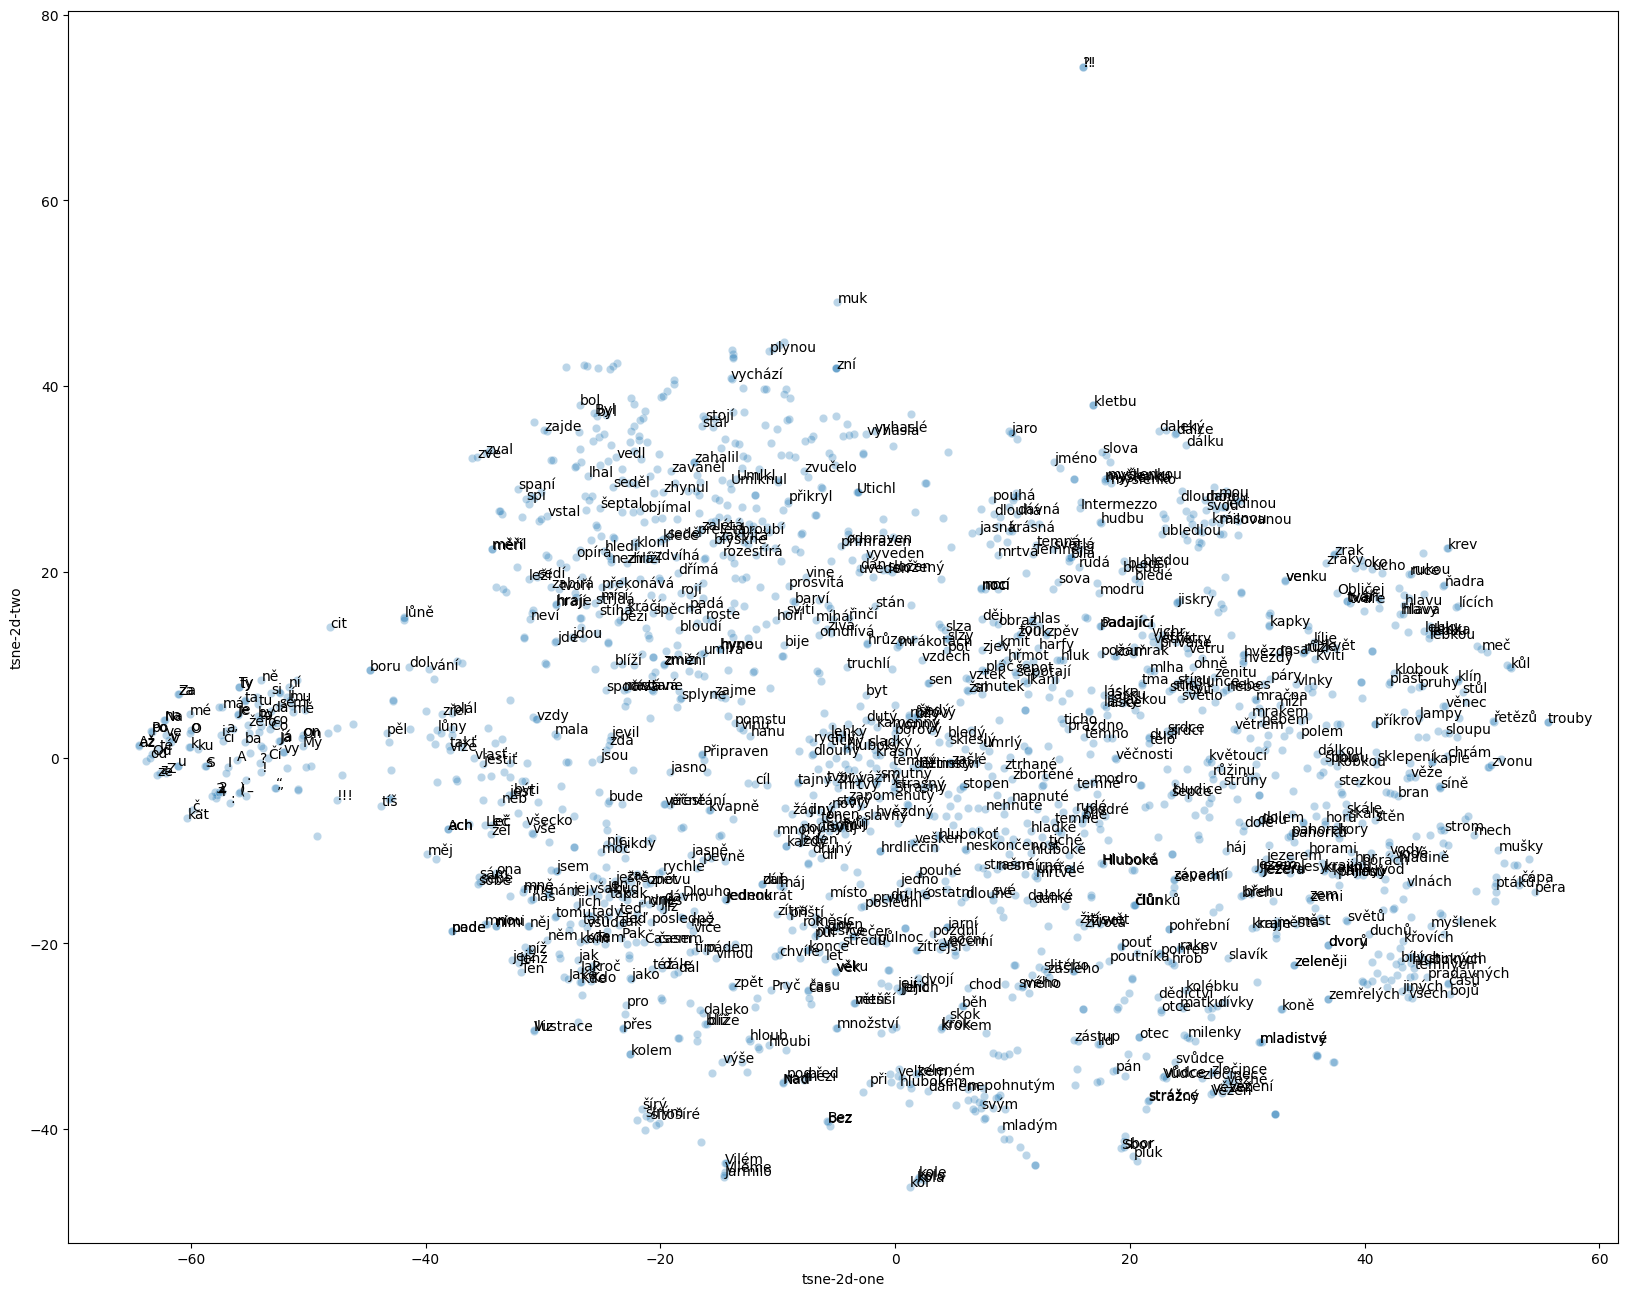

In [ ]:
df_subset["word"] = words
df_subset['tsne-2d-one'] = tsne_em[:,0]
df_subset['tsne-2d-two'] = tsne_em[:,1]
df_subset['count'] = [counts[w] for w in words]
## because the graph would be unreadable if displaying labels for all words
## you can change the number below
df_subset['disp_word'] = [w if counts[w]>1 else '' for w in words]
plt.figure(figsize=(20,16))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3
)

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

label_point(df_subset['tsne-2d-one'], df_subset['tsne-2d-two'], df_subset['disp_word'], plt.gca())

Naturally, it seems that the word vectors make some clusters. Let's use some algorithm to find them. Afterwards, let's check that the clusters make sense.

In [ ]:
n_clusters=12 # feel free to change this number and re-run the cells below

In [ ]:
k = KMeans(n_clusters=n_clusters).fit(word_vectors)
k.labels_
df_subset['cluster']=k.labels_

In [ ]:
pd.options.display.max_rows = 40

In [ ]:
df_subset[['word', 'count', 'cluster']]

,word,count,cluster
0,ve,8,3
1,srdci,3,8
2,vás,1,2
3,své,3,0
4,svírá,1,4
...,...,...,...
1913,vodách,1,4
1914,časy,1,8
1915,poslez,1,4
1916,Nad,2,0


In [ ]:
df_subset.loc[df_subset['cluster']==9][['word', 'count', 'cluster']].sort_values(by='count')

,word,count,cluster
1043,Vše,1,9
928,Čas,1,9
1594,čem,1,9
130,Zde,1,9
1153,Dál,1,9
895,Než,1,9
868,Kudy,1,9
1382,čím,1,9
358,proč,1,9
572,Kdy,1,9


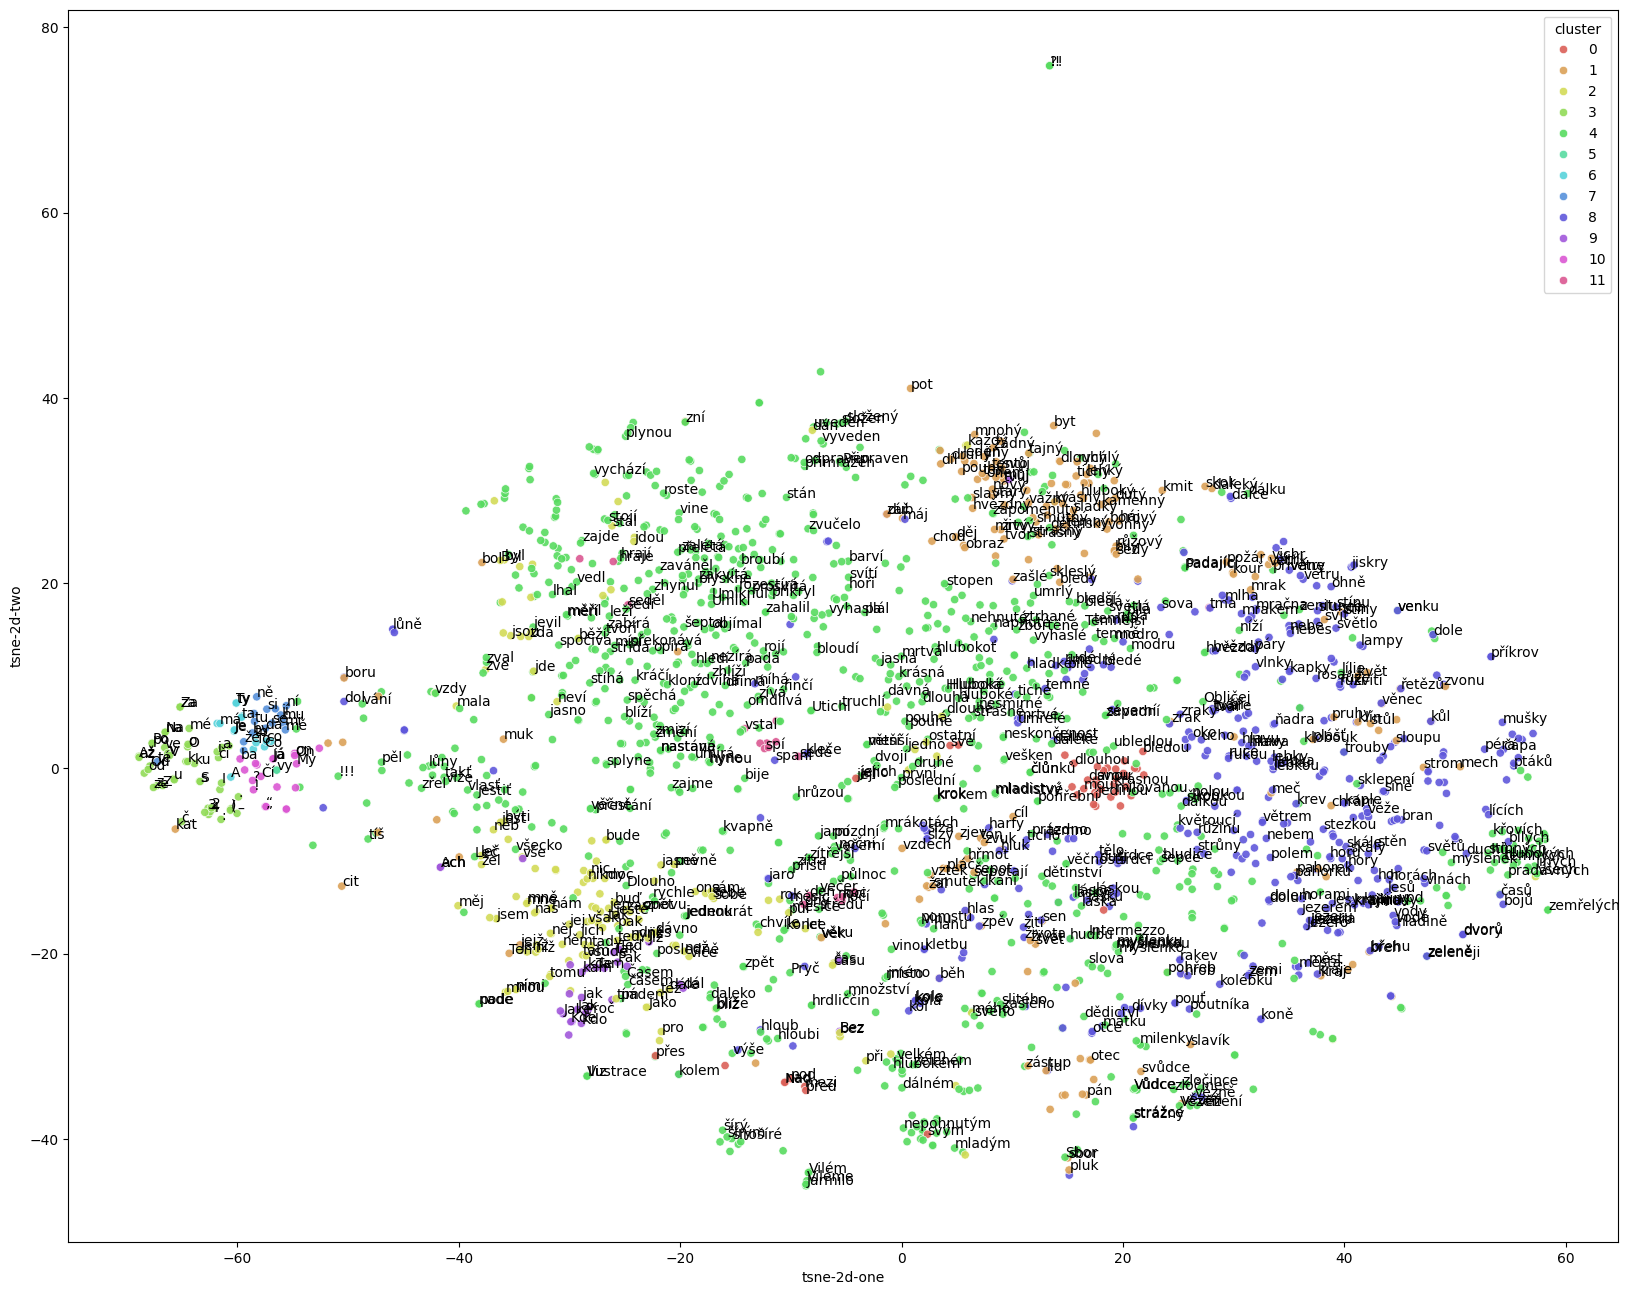

In [ ]:
plt.figure(figsize=(20,16))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    palette=sns.color_palette("hls", n_clusters),
    data=df_subset,
    legend="full",
    alpha=0.9,
    hue='cluster'
)

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

label_point(df_subset['tsne-2d-one'], df_subset['tsne-2d-two'], df_subset['disp_word'], plt.gca())